In [1]:
#import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

In [2]:
import librosa
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import librosa.display
import scipy
import glob
import os
import datetime

# load the tensorboard notebook extension
%load_ext tensorboard

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9363302256237743666,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5492944969507223047
 physical_device_desc: "device: XLA_CPU device"]

In [4]:
tf.random.set_seed(999)
np.random.seed(999)

In [5]:
path_to_dataset = "/home/abhish/Documents/CED Denoising/Code/records/"

In [6]:
# get training and validation tf record file names
train_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset,'train_*'))
val_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset,'val_*'))

# shuffle the file names for training
np.random.shuffle(train_tfrecords_filenames)
print("Training file names:",train_tfrecords_filenames)
print("Validation file names:", val_tfrecords_filenames)

Training file names: ['/home/abhish/Documents/CED Denoising/Code/records/train_1.tfrecords', '/home/abhish/Documents/CED Denoising/Code/records/train_0.tfrecords', '/home/abhish/Documents/CED Denoising/Code/records/train_2.tfrecords', '/home/abhish/Documents/CED Denoising/Code/records/train_3.tfrecords']
Validation file names: ['/home/abhish/Documents/CED Denoising/Code/records/val_0.tfrecords']


In [7]:
# Parameters about window and audio
windowLength = 256
overlap = round(0.25 * windowLength) #overlap of 75%
fftLength = windowLength
inputFs = 48e3
fs = 16e3
numFeatures = fftLength//2 + 1
numSegments = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",fftLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 16000.0
numFeatures: 129
numSegments: 8


In [43]:
mozilla_basepath = '/home/abhish/Documents/Dataset/MozillaDataset'
urbansound_basepath = '/home/abhish/Documents/Dataset/UrbanSound8K'

## Prepare Input Features

In [8]:
def tf_record_parser(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((),tf.string,default_value = ""),
        "noise_stft_mag_features": tf.io.FixedLenFeature([],tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((),tf.string)
    }
    
    features = tf.io.parse_single_example(record,keys_to_features)
    
    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'],tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'],tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'],tf.float32)
    
    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features,(129,8,1),name = "noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude,(129,1,1),name = "clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase,(129,),name = "noise_stft_phase")
    
    return noise_stft_mag_features,clean_stft_magnitude

## Create tf.Data.Dataset

In [9]:
train_dataset = tf.data.TFRecordDataset([train_tfrecords_filenames])
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.shuffle(buffer_size = 50)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [10]:
# explore dataset
print(train_dataset.take(1))

<TakeDataset shapes: ((None, 129, 8, 1), (None, 129, 1, 1)), types: (tf.float32, tf.float32)>


In [11]:
test_dataset = tf.data.TFRecordDataset([val_tfrecords_filenames])
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(32)

## Model Training

In [12]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential

In [14]:
def conv_block(x,filters,kernel_size,strides,padding = 'same',use_bn = True):
    x = Conv2D(filters = filters, 
               kernel_size = kernel_size, 
               strides = strides, 
               padding = padding, 
               use_bias = False,
               kernel_regularizer = tf.keras.regularizers.l2(0.0006)
              )(x)
    
    x = Activation('relu')(x)
    if use_bn:
        x = BatchNormalization()(x)
    return x

In [15]:
def full_pre_activation_block(x,filters,kernel_size,strides,padding='same',use_bn = True):
    shortcut = x
    in_channels = x.shape[-1]
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filter = filters,
               kernel_size = kernel_size,
               strides = strides,
               padding = 'same'
              )(x)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = in_channels,
               kernel_size = kernel_size,
               strides = strides,
               padding = 'same'
              )(x)
    
    return shortcut + x

In [25]:
def build_model(l2_strength):
    inputs = Input(shape = [numFeatures,numSegments,1])
    x = inputs
    x = tf.keras.layers.ZeroPadding2D(((4,4),(0,0)))(x)
    
    # 1. -----------------------------------------------------------
    
    x = Conv2D(name = "I.Conv",
              filters = 18,
              kernel_size = [9,8],
              strides = [1,1],
              padding = 'valid',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    skip0 = Conv2D(name = "II.Conv.S",
                   filters = 30,
                   kernel_size = [5,1],
                   strides = [1,1],
                   padding = 'same',
                   use_bias = False,
                   kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
                  )(x)
    x = Activation('relu')(skip0)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "III.Conv",
              filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # 2. ----------------------------------------------------------
    
    x = Conv2D(name = "IV.Conv",
              filters = 18,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    skip1 = Conv2D(name = "V.Conv.S",
                   filters = 30,
                   kernel_size = [5,1],
                   strides = [1,1],
                   padding = 'same',
                   use_bias = False,
                   kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
                  )(x)
    x = Activation('relu')(skip1)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "VI.Conv",
              filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # 3. ----------------------------------------------------------
    
    x = Conv2D(name = "VII.Conv",
              filters = 18,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "VIII.Conv",
              filters = 30,
              kernel_size = [5,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "IX.Conv",
              filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # 4. ----------------------------------------------------------
    
    x = Conv2D(name = "X.Conv",
              filters = 18,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "XI.Conv.ADD.V.Conv",
              filters = 30,
              kernel_size = [5,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    
    x = x + skip1
    
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "XII.Conv",
              filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # 5. ----------------------------------------------------------
    
    x = Conv2D(name = "XIII.Conv",
              filters = 18,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "XIV.Conv.ADD.II.Conv",
              filters = 30,
              kernel_size = [5,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    
    x = x + skip0
    
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "XV.Conv",
              filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    #----------------------------------------------------------
    
    
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)
    x = Conv2D(name = "XVI.Conv",
               filters = 1,
               kernel_size = [129,1],
               strides = [1,1],
               padding = 'same'
              )(x)
    
    model = Model(inputs = inputs, outputs = x)
    
    optimizer = tf.keras.optimizers.Adam(3e-4)
    
    model.compile(optimizer = optimizer,
                  loss = 'mse',
                  metrics = [tf.keras.metrics.RootMeanSquaredError('rmse')]
                 )
    
    return model   
    

In [26]:
model = build_model(l2_strength = 0.0)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 129, 8, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 137, 8, 1)    0           input_6[0][0]                    
__________________________________________________________________________________________________
I.Conv (Conv2D)                 (None, 129, 1, 18)   1296        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 129, 1, 18)   0           I.Conv[0][0]                     
_______________________________________________________________________________________

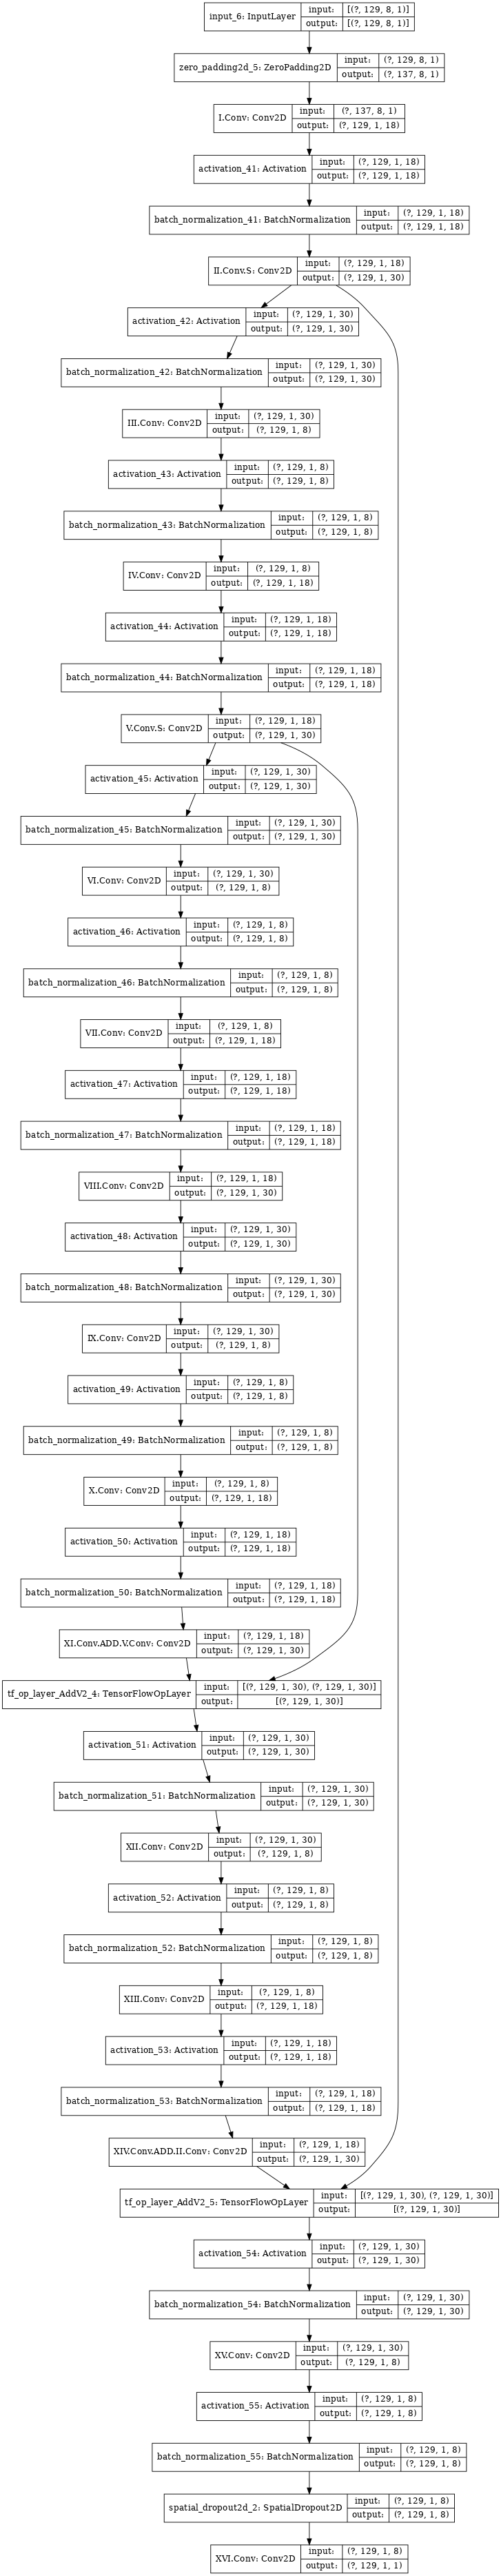

In [27]:
tf.keras.utils.plot_model(model,show_shapes = True,dpi = 64)

In [28]:
%tensorboard --logdir logs

In [29]:
baseline_val_loss = model.evaluate(test_dataset)[0]
print(f"Baseline accuracy {baseline_val_loss}")

629/629 [==============================] - 14s 21ms/step - loss: 0.6277 - rmse: 0.7923
Baseline accuracy 0.62770015001297


In [30]:
def l2_norm(vector):
    return np.square(vector)

def SDR(denoised,cleaned,eps = 1e-7):
    a = l2_norm(denoised)
    b = l2_norm(denoised_clean)
    a_b = a / b
    return np.mean(10 * np.log10(a_b + eps))

In [31]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                          patience = 50,
                                                          restore_best_weights = True,
                                                          baseline = None)
logdir = os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,update_freq = 'batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = './denoiser_cnn_log_mel_generator.h5',
                                                        monitor = 'val_loss',
                                                        save_best_only = True)

model.fit(train_dataset,
         steps_per_epoch = 50,
         validation_data = test_dataset,
         epochs = 50,
         callbacks = [early_stopping_callback,tensorboard_callback,checkpoint_callback])

Epoch 1/50
 1/50 [..............................] - ETA: 0s - loss: 2.5609 - rmse: 1.6003WARNING:tensorflow:From /home/abhish/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
50/50 [==============================] - 15s 309ms/step - loss: 1.2882 - rmse: 1.1350 - val_loss: 0.5503 - val_rmse: 0.7418
Epoch 2/50
50/50 [==============================] - 16s 319ms/step - loss: 0.6994 - rmse: 0.8363 - val_loss: 0.5146 - val_rmse: 0.7174
Epoch 3/50
50/50 [==============================] - 16s 325ms/step - loss: 0.5139 - rmse: 0.7169 - val_loss: 0.4371 - val_rmse: 0.6611
Epoch 4/50
50/50 [==============================] - 16s 323ms/step - loss: 0.4955 - rmse: 0.7039 - val_loss: 0.3845 - val_rmse: 0.6201
Epoch 5/50
50/50 [==============================] - 16s 323ms/step - loss: 0.4208 - 

## Testing

In [70]:
import sys
# Add module directory
sys.path.append('../')
from data_processing.feature_extractor import FeatureExtractor
from data_processing.mozilla_common_voice import MozillaCommonVoiceDataset
from data_processing.urban_sound import UrbanSound8K
from data_processing.dataset import Dataset
from utils import read_audio, add_noise_to_clean_audio, play, prepare_input_features, revert_features_to_audio

#### Sample one random clean data, and one random noisy data from the dataset and clean it using model

In [48]:
mcv = MozillaCommonVoiceDataset(mozilla_basepath,val_dataset_size = 100)
clean_test_filenames = mcv.get_test_filenames()
clean_filename = np.random.choice(clean_test_filenames)
print(clean_filename)
print("\r\n")

us8k = UrbanSound8K(urbansound_basepath,val_dataset_size = 100)
noise_test_filenames = us8k.get_test_filenames()
noise_filename = np.random.choice(noise_test_filenames)
print(noise_filename)

Total number of training examples: 500
# of Testing clean files: 500
/home/abhish/Documents/Dataset/MozillaDataset/clips/dcc9b457f9003152cb8765d1d8472bb4c32fdc95013f2bdda9e52e68221ddcabb5c847a7337f10a02a9a5e0ff45465ae612eda2e88752a8a8aebce556bd82802.mp3


Number of classes: [0 1 2 3 4 5 6 7 8 9]
Class c: 0 has: 8 files
Class c: 1 has: 2 files
Class c: 2 has: 6 files
Class c: 3 has: 5 files
Class c: 4 has: 6 files
Class c: 5 has: 7 files
Class c: 6 has: 1 files
Class c: 7 has: 7 files
Class c: 8 has: 5 files
Class c: 9 has: 2 files
# of Noise testing files: 49
/home/abhish/Documents/Dataset/UrbanSound8K/audio/fold10/93567-8-0-11.wav


#### Prepare input feature for filtering

In [50]:
cleanAudio, sr = read_audio(clean_filename,sample_rate = fs)
print("Min:",np.min(cleanAudio), "Max:",np.max(cleanAudio))
ipd.Audio(data = cleanAudio, rate = sr) # load a local WAV file

/home/abhish/anaconda3/envs/ml/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Min: -0.30260694 Max: 0.33333334


In [51]:
noiseAudio,sr = read_audio(noise_filename,sample_rate = fs)
print("Min:",np.min(noiseAudio),"Max:",np.max(noiseAudio))
ipd.Audio(data = noiseAudio,rate = sr)

Min: -0.33333334 Max: 0.3276132


In [57]:
cleanAudioFE = FeatureExtractor(cleanAudio,windowLength = windowLength,
                               overlap = overlap,
                               sample_rate = fs) 
clean_stft_features = cleanAudioFE.get_stft_spectrogram()
clean_stft_features = np.abs(stft_features)
print("Min:",np.min(clean_stft_features), "Max:",np.max(clean_stft_features))

Min: 0.0 Max: 14.172824


In [58]:
noisyAudio = add_noise_to_clean_audio(cleanAudio,noiseAudio)
ipd.Audio(data = noisyAudio,rate = fs) # load a local WAV file

In [59]:
noisyAudioFE = FeatureExtractor(noisyAudio,windowLength = windowLength,
                               overlap = overlap,
                               sample_rate = fs) 
noisy_stft_features = noiseAudioFE.get_stft_spectrogram()

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to 
# perform inverse STFT and recover human speech

noisyPhase = np.angle(noisy_stft_features)
print("noisy phase shape:",noisyPhase.shape)
noisy_stft_features = np.abs(noisy_stft_features)

mean = np.mean(noisy_stft_features)
std = np.std(noisy_stft_features)
noisy_stft_features = (noisy_stft_features - mean) / std

noisy phase shape: (129, 1001)


In [63]:
predictors = prepare_input_features(noisy_stft_features,
                                    numSegments = numSegments,
                                    numFeatures = numFeatures
                                   )

In [64]:
predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
predictors = np.transpose(predictors,(3,0,1,2)).astype(np.float32)
print('predictors shape:',predictors.shape)

predictors shape: (1001, 129, 8, 1)


In [65]:
STFTFullyConvolutional = model.predict(predictors)
print(STFTFullyConvolutional.shape)

(1001, 129, 1, 1)


In [74]:
denoisedAudioFC = revert_features_to_audio(features = STFTFullyConvolutional,
                                           phase = noisyPhase,
                                           window_length = windowLength,
                                           overlap = overlap,
                                           cleanMean = mean,
                                           cleanStd = std)
print("Min:", np.min(denoisedAudioFC), "Max:", np.max(denoisedAudioFC))
ipd.Audio(data = denoisedAudioFC, rate = fs)

Min: -0.10606582 Max: 0.12028611


Text(0.5, 1.0, 'Denoised Audio')

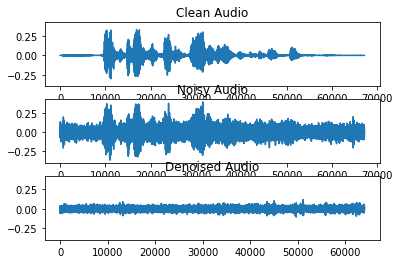

In [75]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

ax1.plot(cleanAudio)
ax1.set_title("Clean Audio")

ax2.plot(noisyAudio)
ax2.set_title("Noisy Audio")

ax3.plot(denoisedAudioFC)
ax3.set_title("Denoised Audio")
